In [1]:
# data pre processing
crimes <- read.csv("../data/crimes.csv")
crimes$region_central <- crimes$region == "central"
crimes$region_west <- crimes$region == "west"
# crimes$region_other <- crimes$region == "other"

crimes$region_central <- as.integer(as.logical(crimes$region_central))
crimes$region_west <- as.integer(as.logical(crimes$region_west))
# crimes$region_other <- as.integer(as.logical(crimes$region_other))

crimes <- subset(crimes, select = -c(region, name))
crimes$crimes <- round(log(crimes$crimes))

In [2]:
# functions for the design matrix
# install.packages("dplyr")
require(dplyr)

rnd_design_matrix <- function(original_data, num_rows) {
    des_mx <- data.frame(original_data) # copy the data frame
    des_mx <- des_mx[0,] # delete all rows
    
    for (i in 1 : num_rows) {
        # Add the row
        des_mx <- rbind(des_mx, sample_n(original_data, 1))
    }
    
    return(des_mx)
}

add_to_design_matrix <- function(curr_design_matrix, original_data, num_rows){
    des_mx <- data.frame(curr_design_matrix) # copy the data frame
    
    for (i in 1 : num_rows) {
        # Add the row
        des_mx <- rbind(des_mx, sample_n(original_data, 1))
    }
    
    return(des_mx)
}

Loading required package: dplyr


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




In [3]:
# calculates the confidence intervalls for a model
likelihood_confidence <- function(model, alpha){
    df <- as.data.frame(matrix(ncol = 2))
    colnames(df) <- c("2.5%", "97.5%")
    df <- df[0,]
    
    bound = 1 - alpha/2
    
    row_names <- c()
    
    for (i in 1:length(coef(model))){
        l_bound = coef(model)[i] - qnorm(bound) * sqrt(vcov(model)[i,i])
        u_bound = coef(model)[i] + qnorm(bound) * sqrt(vcov(model)[i,i])
        
        name = names(coef(model)[i])
        row_names <- append(row_names, name)
        
        df[nrow(df) + 1,] = c(l_bound,u_bound)
    }
    rownames(df) <- row_names
    return(df)
}

In [4]:
# get confidence intervalls for pseudo observations
get_intervals <- function(design_matrix, mu){
    # simulate pseudo observations
    n = nrow(design_matrix)
    y.sim = rpois(n, mu)
    
    # learn model
    m = glm(y.sim~1+prbarr+prbpris, data=design_matrix, family=poisson(link="log"))
    
    # Calculate confidence intervalls
    my_conf = likelihood_confidence(m, 0.05)
    r_conf = suppressMessages(confint(m))
    
    return(list(my_conf, r_conf))
}

# get m confidence intervalls for m different pseudo observations
get_m_intervals <- function(m, design_matrix, mu){
    intervals = get_intervals(design_matrix, mu)
    my_conf = intervals[[1]]
    r_conf = intervals[[2]]
    
    my_m_intervals = data.frame(my_conf)
    r_m_intervals = data.frame(r_conf)
    
    for (i in 1:(m-1)){
        intervals = get_intervals(design_matrix, mu)
        my_conf = intervals[[1]]
        r_conf = intervals[[2]]
        
        my_m_intervals = cbind(my_m_intervals, my_conf)
        r_m_intervals = cbind(r_m_intervals, r_conf)
    }
    
    return(list(my_m_intervals, r_m_intervals))
}

# evaluates the m intervals in comparison to the true coefficients
eval_m_intervals <- function(true_coef, my_m_intervals, r_m_intervals){
    num_coef = nrow(true_coef)
    m = ncol(my_m_intervals)/2
    
    r_conf_hits = my_conf_hits = rep(0, length.out=num_coef)
    
    for (j in 1:m){
        l_bound = my_m_intervals[ , j*2 - 1]
        u_bound = my_m_intervals[ , j*2]       
        for (i in 1:num_coef){
            coe = true_coef[i,1]           
            if (coe > l_bound[i] && coe < u_bound[i]){
                my_conf_hits[i] = my_conf_hits[i] + 1
            }
        }
        
        l_bound = r_m_intervals[ , j*2 - 1]
        u_bound = r_m_intervals[ , j*2]
        for (i in 1:num_coef){
            coe = true_coef[i,1]
            if (coe > l_bound[i] && coe < u_bound[i]){
                r_conf_hits[i] = r_conf_hits[i] + 1
            }
        }
    }
    
    r_conf_hits = r_conf_hits / m
    my_conf_hits = my_conf_hits / m
    
    return(list(my_conf_hits, r_conf_hits))
}

In [5]:
experiment = function(data, n_start, increase, num_times, m){
    des_matrix = rnd_design_matrix(data, n_start) # create first design matrix
    
    # learn true model with the true design matrix
    true_model = glm(crimes~1+prbarr+prbpris, data=des_matrix, family=poisson(link="log"))
    true_mu = predict(true_model, type="response")
    true_coef = data.frame(coefficients=coef(true_model))
    
    # first iteration
    # simulate observations and compare with true values
    intervals = get_m_intervals(m, des_matrix, true_mu)
    my_conf = intervals[[1]]
    r_conf = intervals[[2]]
    hits = eval_m_intervals(true_coef, r_conf, my_conf)
    
    r_res = data.frame(n_start = hits[[1]])
    my_res = data.frame(n_start = hits[[2]])
    
    rownames(r_res) = names(coef(true_model))
    rownames(my_res) = names(coef(true_model))
    
    colnames(r_res) = c(n_start)
    colnames(my_res) = c(n_start)
    
    
    for (n in 1:num_times-1){
        des_matrix = add_to_design_matrix(des_matrix, crimes, increase)
        
        # learn true model with the true design matrix
        true_model = glm(crimes~1+prbarr+prbpris, data=des_matrix, family=poisson(link="log"))
        true_mu = predict(true_model, type="response")
        true_coef = data.frame(coefficients=coef(true_model))
        
        # simulate observations and compare with true values
        intervals = get_m_intervals(m, des_matrix, true_mu)
        my_conf = intervals[[1]]
        r_conf = intervals[[2]]
        hits = eval_m_intervals(true_coef, r_conf, my_conf)
        
        temp_r_res = data.frame(x = hits[[1]])
        temp_my_res = data.frame(x = hits[[2]])
        
        colnames(temp_r_res) = c(nrow(des_matrix))
        colnames(temp_my_res) = c(nrow(des_matrix))
                
        r_res = cbind(r_res, temp_r_res)
        my_res = cbind(my_res, temp_my_res)
    }
    
    return(list(r_res, my_res))
}

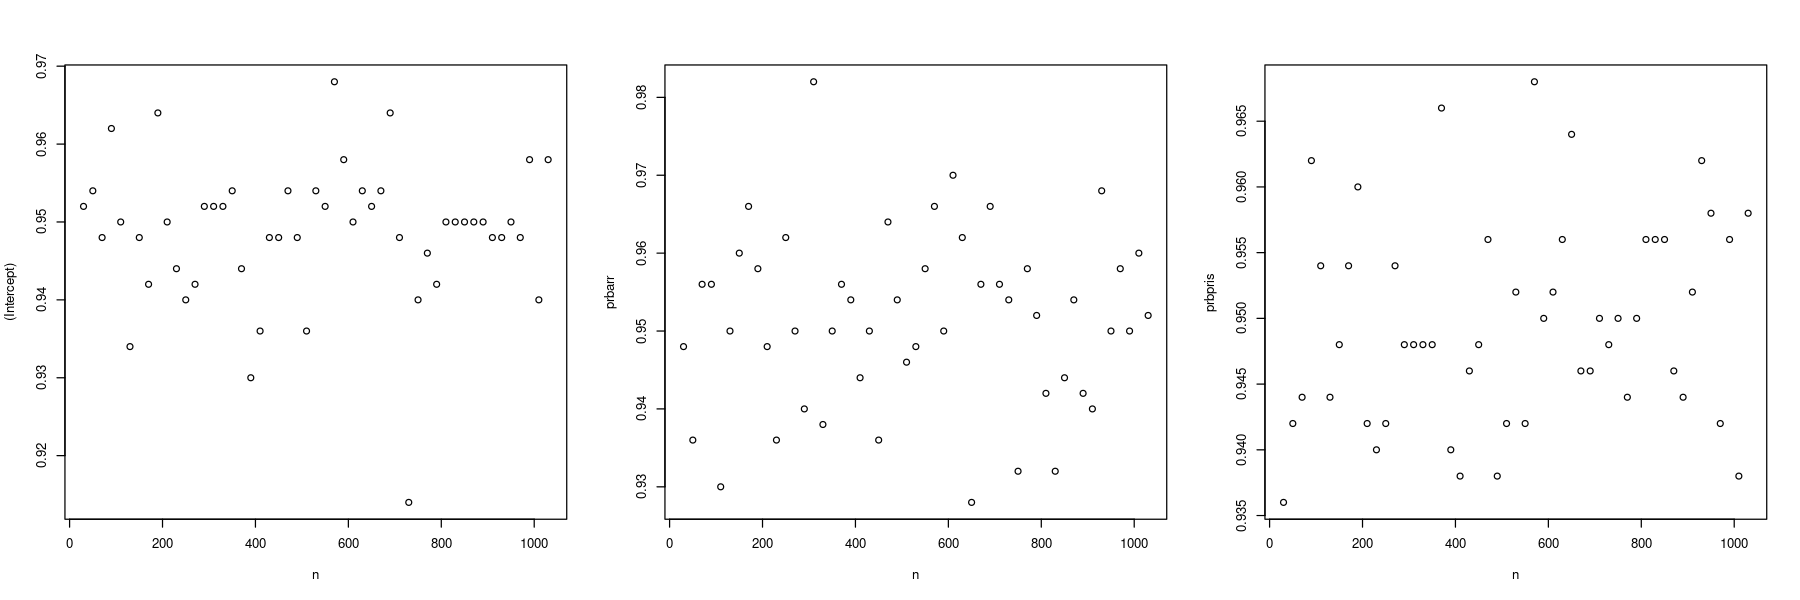

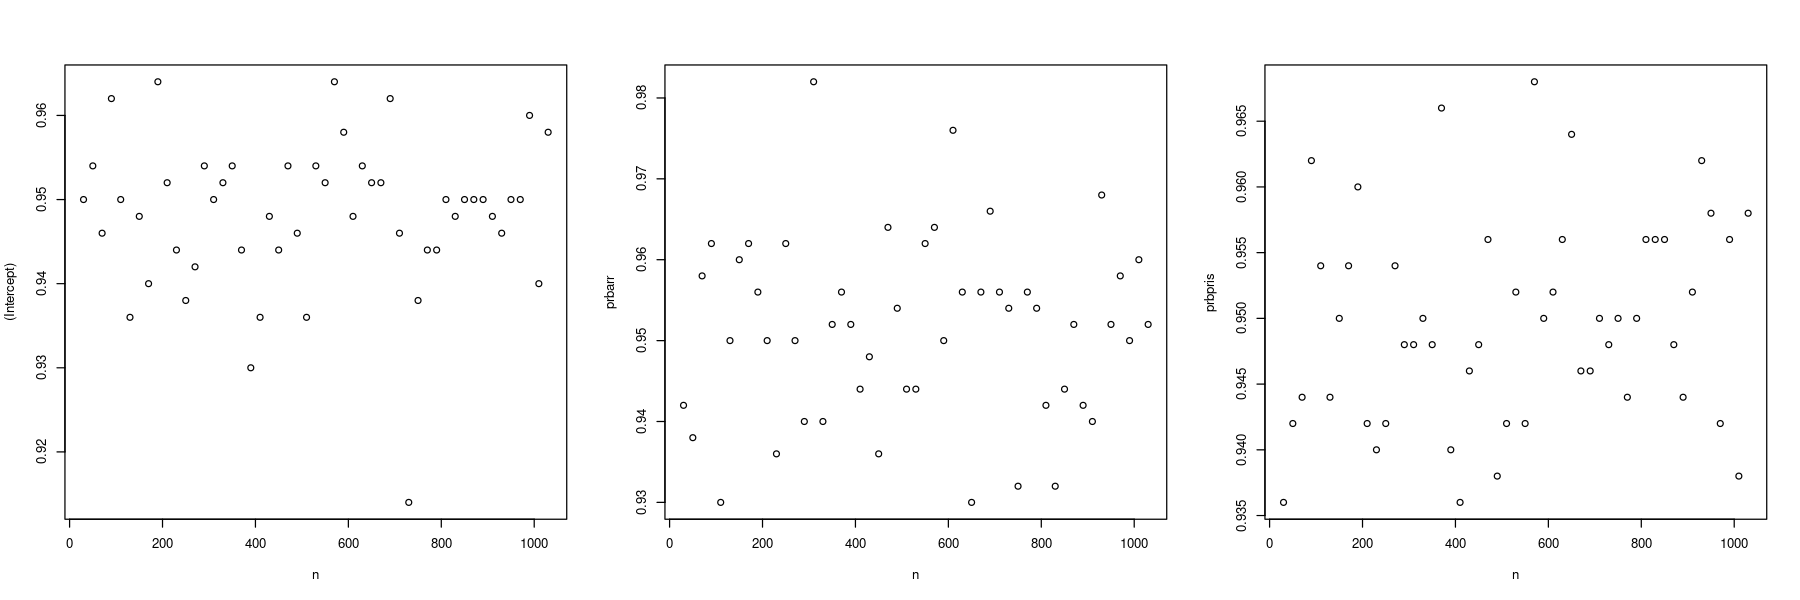

In [6]:
res = experiment(crimes, 30, 20, 50, 500)
r_res = res[[1]]
my_res = res[[2]]

r_res = rbind(as.numeric(colnames(r_res)), r_res)
my_res = rbind(as.numeric(colnames(my_res)), my_res)

r_res = t(r_res)
my_res = t(my_res)

options(repr.plot.width = 15, repr.plot.height = 5)
par(mfrow=c(1,3))

plot(r_res[, 1], r_res[, 2], xlab="n", ylab="(Intercept)")
plot(r_res[, 1], r_res[, 3], xlab="n", ylab="prbarr")
plot(r_res[, 1], r_res[, 4], xlab="n", ylab="prbpris")

plot(my_res[, 1], my_res[, 2], xlab="n", ylab="(Intercept)")
plot(my_res[, 1], my_res[, 3], xlab="n", ylab="prbarr")
plot(my_res[, 1], my_res[, 4], xlab="n", ylab="prbpris")

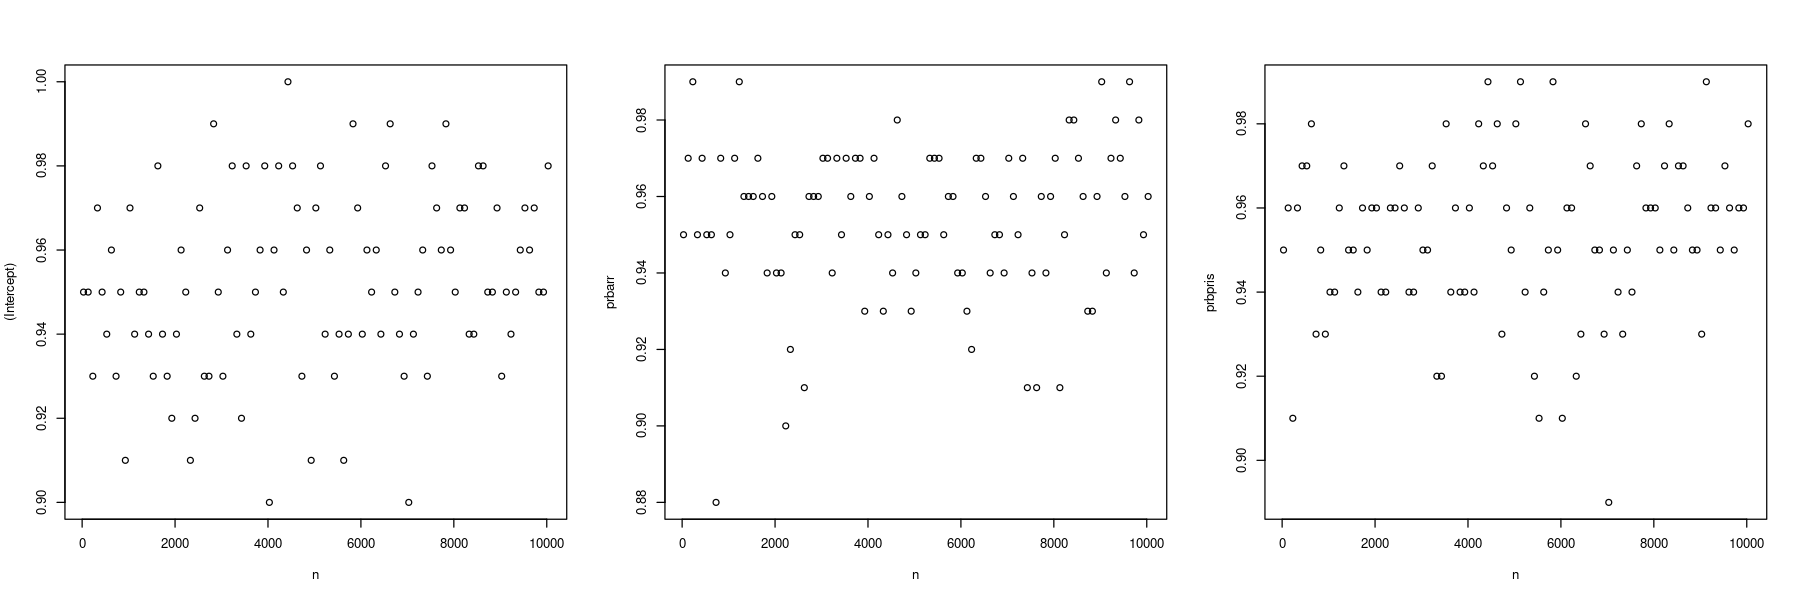

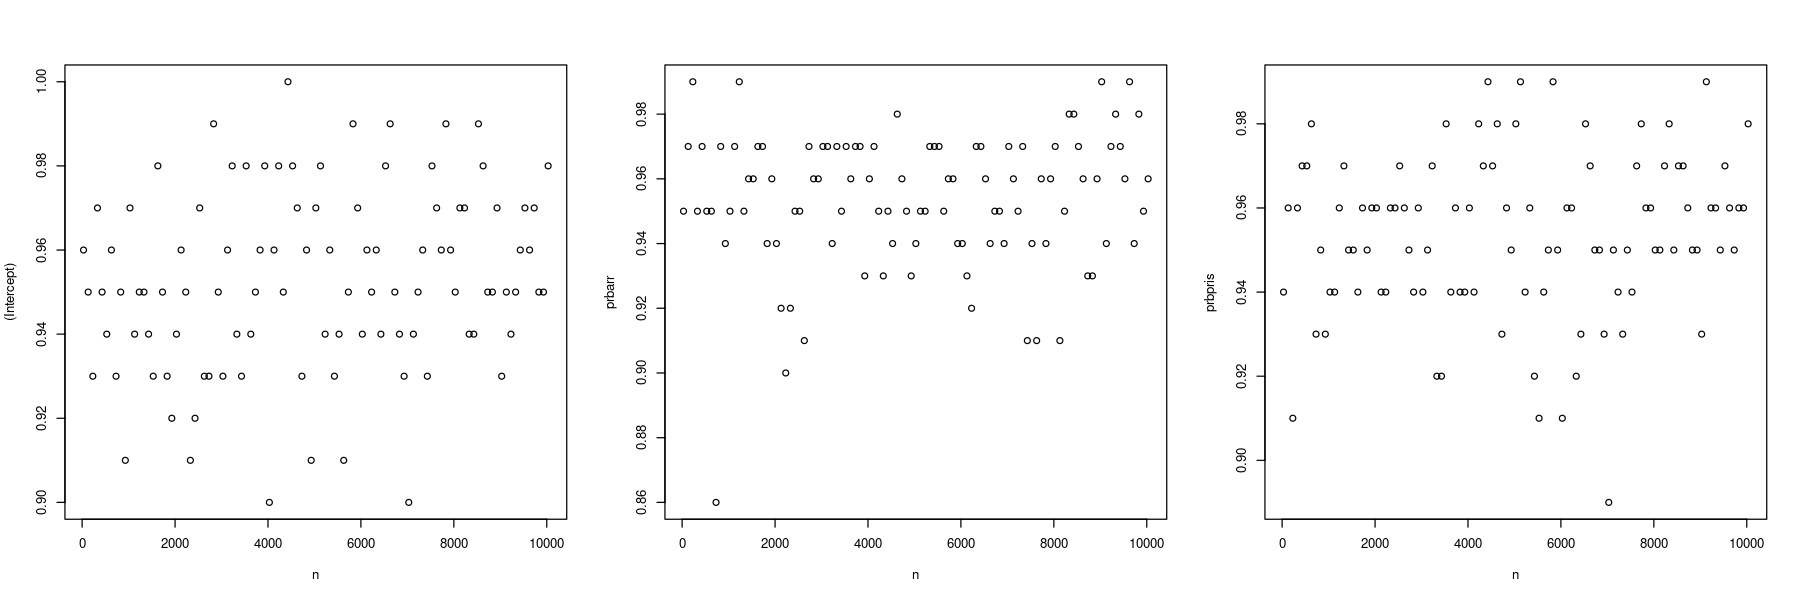

In [8]:
res = experiment(crimes, 30, 100, 100, 100)
r_res = res[[1]]
my_res = res[[2]]

r_res = rbind(as.numeric(colnames(r_res)), r_res)
my_res = rbind(as.numeric(colnames(my_res)), my_res)

r_res = t(r_res)
my_res = t(my_res)

options(repr.plot.width = 15, repr.plot.height = 5)
par(mfrow=c(1,3))

plot(r_res[, 1], r_res[, 2], xlab="n", ylab="(Intercept)")
plot(r_res[, 1], r_res[, 3], xlab="n", ylab="prbarr")
plot(r_res[, 1], r_res[, 4], xlab="n", ylab="prbpris")

plot(my_res[, 1], my_res[, 2], xlab="n", ylab="(Intercept)")
plot(my_res[, 1], my_res[, 3], xlab="n", ylab="prbarr")
plot(my_res[, 1], my_res[, 4], xlab="n", ylab="prbpris")

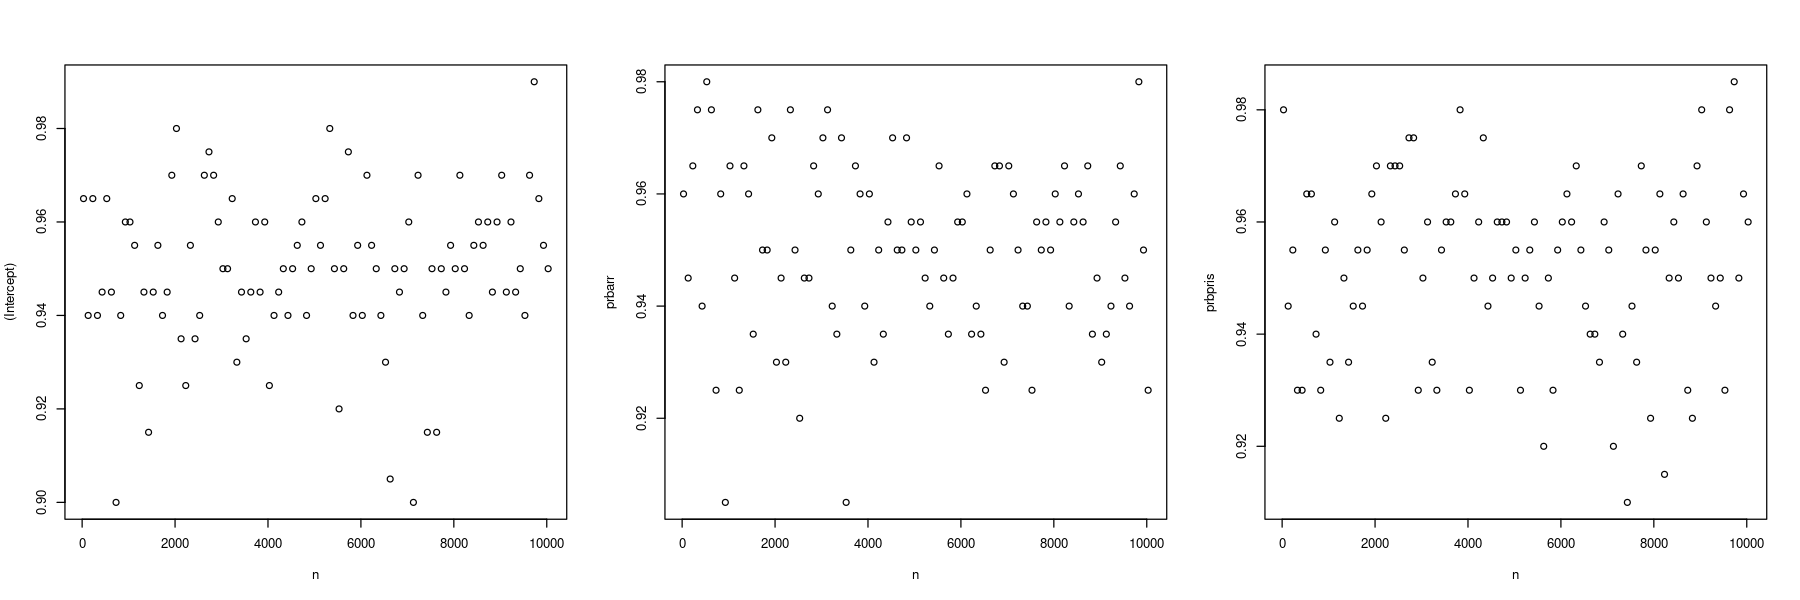

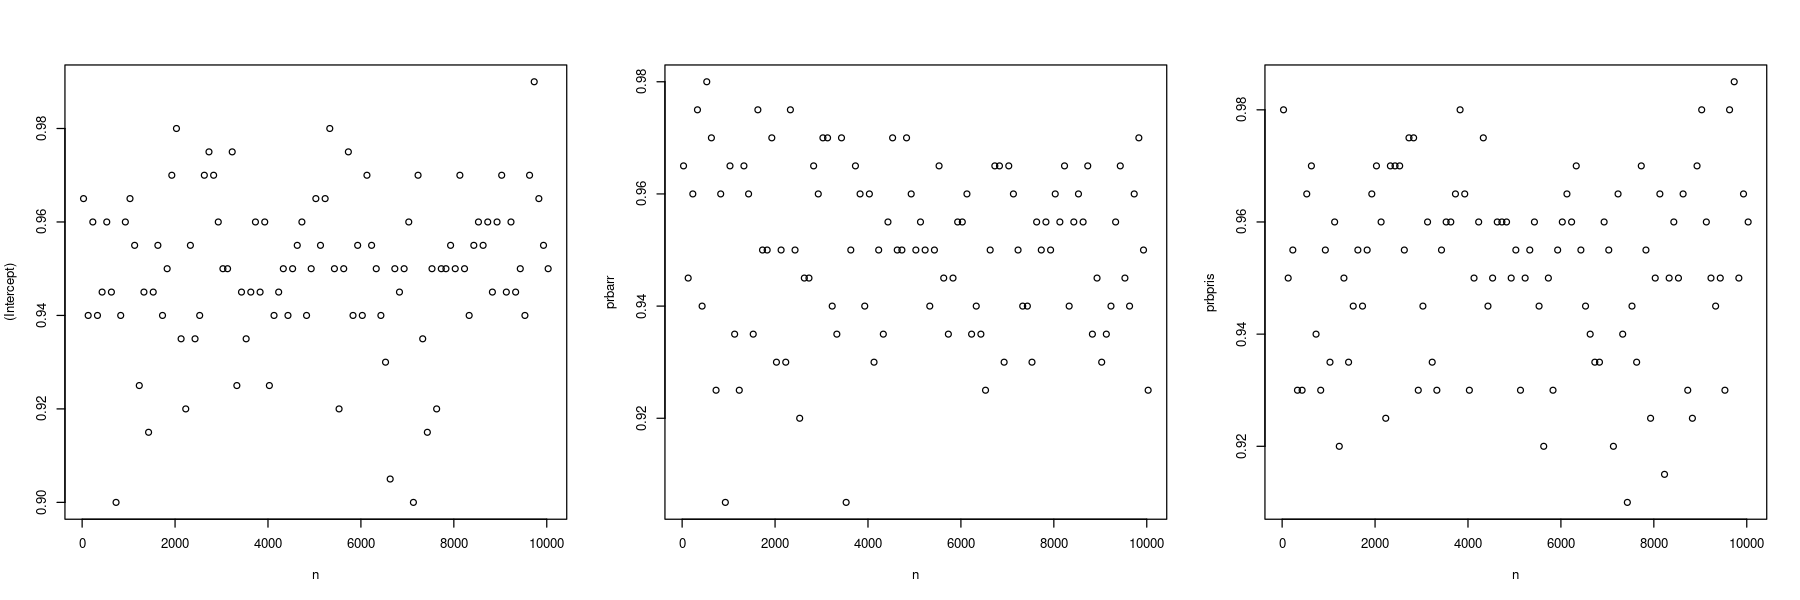

In [9]:
res = experiment(crimes, 30, 100, 100, 200)
r_res = res[[1]]
my_res = res[[2]]

r_res = rbind(as.numeric(colnames(r_res)), r_res)
my_res = rbind(as.numeric(colnames(my_res)), my_res)

r_res = t(r_res)
my_res = t(my_res)

options(repr.plot.width = 15, repr.plot.height = 5)
par(mfrow=c(1,3))

plot(r_res[, 1], r_res[, 2], xlab="n", ylab="(Intercept)")
plot(r_res[, 1], r_res[, 3], xlab="n", ylab="prbarr")
plot(r_res[, 1], r_res[, 4], xlab="n", ylab="prbpris")

plot(my_res[, 1], my_res[, 2], xlab="n", ylab="(Intercept)")
plot(my_res[, 1], my_res[, 3], xlab="n", ylab="prbarr")
plot(my_res[, 1], my_res[, 4], xlab="n", ylab="prbpris")